In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import label_ranking_average_precision_score


In [2]:
# Constants
SEED = 42

In [3]:
# Loading the datasets
train_file_path = "dataset/train.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "dataset/test.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

# DATA EXPLORATION

In [4]:
# Basic Info about Dataset
print("\n🔹 Dataset Info:")
print(df.info())


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB
None


In [5]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())


🔍 Missing Values Count:
id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [6]:
# Summary Statistics
print("\n📊 Summary Statistics (Numerical Features):")
print(df.describe())


📊 Summary Statistics (Numerical Features):
                  id    Temparature  ...      Potassium    Phosphorous
count  750000.000000  750000.000000  ...  750000.000000  750000.000000
mean   374999.500000      31.503565  ...       9.478296      21.073227
std    216506.495284       4.025574  ...       5.765622      12.346831
min         0.000000      25.000000  ...       0.000000       0.000000
25%    187499.750000      28.000000  ...       4.000000      10.000000
50%    374999.500000      32.000000  ...       9.000000      21.000000
75%    562499.250000      35.000000  ...      14.000000      32.000000
max    749999.000000      38.000000  ...      19.000000      42.000000

[8 rows x 7 columns]


### EMBEDDING/ENCODING CATEGORICAL VARIABLES

In [7]:
le_1 = LabelEncoder()
train_df['Fertilizer_name_encoded'] = le_1.fit_transform(train_df['Fertilizer Name'].astype(str))

In [8]:
train_df

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,Fertilizer_name_encoded
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,4
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,4
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,2
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,0
4,4,35,58,43,Red,Paddy,37,2,16,DAP,5
...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,28-28,4
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17,2
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26,0
749998,749998,31,68,29,Red,Cotton,9,11,12,20-20,3


In [9]:
for col in ['Soil Type', 'Crop Type']:
    if train_df[col].dtype == 'object' or str(train_df[col].dtype) == 'category':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))


for col in ['Soil Type', 'Crop Type']:
    if test_df[col].dtype == 'object' or str(test_df[col].dtype) == 'category':
        le = LabelEncoder()
        test_df[col] = le.fit_transform(test_df[col].astype(str))



In [10]:
train_df

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,Fertilizer_name_encoded
0,0,37,70,36,1,8,36,4,5,28-28,4
1,1,27,69,65,4,4,30,6,18,28-28,4
2,2,29,63,32,4,4,24,12,16,17-17-17,2
3,3,35,62,54,4,0,39,12,4,10-26-26,0
4,4,35,58,43,3,6,37,2,16,DAP,5
...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,1,3,8,16,6,28-28,4
749996,749996,37,64,58,2,8,38,8,20,17-17-17,2
749997,749997,35,68,59,4,2,6,11,29,10-26-26,0
749998,749998,31,68,29,3,1,9,11,12,20-20,3


# CHECKING CLASS BALANCE

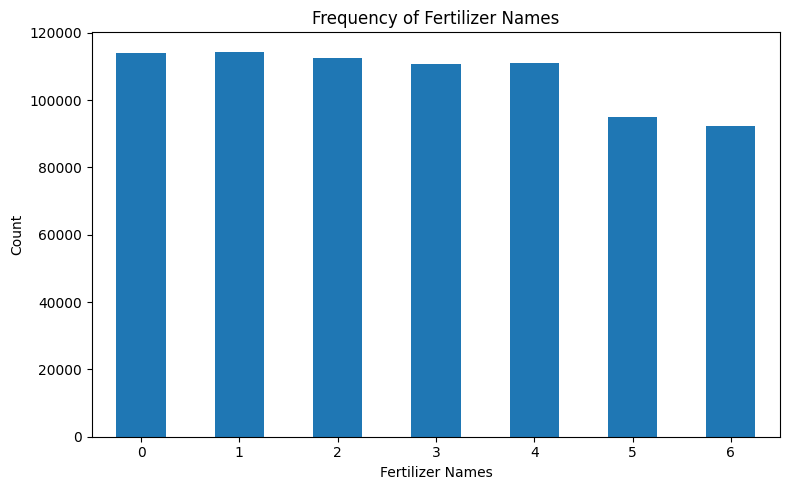

In [12]:
# Frequency count
counts = train_df['Fertilizer_name_encoded'].value_counts().sort_index()

# Plot
counts.plot(kind='bar', figsize=(8, 5))
plt.title('Frequency of Fertilizer Names')
plt.xlabel('Fertilizer Names')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### SCALING TO ZERO MEAN AND UNIT VARIANCE

In [14]:
scaler = StandardScaler() 
column_vals = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df[column_vals]), columns = column_vals)
test_df_scaled = pd.DataFrame(scaler.transform(test_df[column_vals]), columns = column_vals)


In [15]:
train_df_scaled

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
0,1.365380,1.348000,-0.778675,1.150683,-0.950166,-1.301811
1,-1.118740,1.197572,1.680080,0.615738,-0.603282,-0.248908
2,-0.621916,0.295003,-1.117813,0.080794,0.437369,-0.410893
3,0.868556,0.144575,0.747449,1.418155,0.437369,-1.382803
4,0.868556,-0.457138,-0.185182,1.239840,-1.297050,-0.410893
...,...,...,...,...,...,...
749995,-1.615563,1.197572,-1.287383,-1.345725,1.131137,-1.220818
749996,1.365380,0.445431,1.086588,1.328997,-0.256399,-0.086923
749997,0.868556,1.047144,1.171372,-1.524040,0.263927,0.642009
749998,-0.125092,1.047144,-1.372167,-1.256567,0.263927,-0.734863


In [16]:
df_train = pd.concat([train_df_scaled, train_df[['Soil Type', 'Crop Type']]], axis=1)
df_test = pd.concat([test_df_scaled, test_df[['Soil Type', 'Crop Type']]], axis=1)

In [17]:
df_train

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type,Crop Type
0,1.365380,1.348000,-0.778675,1.150683,-0.950166,-1.301811,1,8
1,-1.118740,1.197572,1.680080,0.615738,-0.603282,-0.248908,4,4
2,-0.621916,0.295003,-1.117813,0.080794,0.437369,-0.410893,4,4
3,0.868556,0.144575,0.747449,1.418155,0.437369,-1.382803,4,0
4,0.868556,-0.457138,-0.185182,1.239840,-1.297050,-0.410893,3,6
...,...,...,...,...,...,...,...,...
749995,-1.615563,1.197572,-1.287383,-1.345725,1.131137,-1.220818,1,3
749996,1.365380,0.445431,1.086588,1.328997,-0.256399,-0.086923,2,8
749997,0.868556,1.047144,1.171372,-1.524040,0.263927,0.642009,4,2
749998,-0.125092,1.047144,-1.372167,-1.256567,0.263927,-0.734863,3,1


# CROSS VALIDATION

In [50]:
Y_target = train_df['Fertilizer_name_encoded']
X = df_train
Y_class = train_df['Fertilizer Name']
X_test = df_test

In [60]:
# --- MAP@K IMPLEMENTATION ---
def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.

    Parameters:
    - actual: list or np.array of true labels
    - predicted: list of lists of predicted labels (ranked)
    - k: cutoff rank

    Returns:
    - mean average precision at k
    """
    def apk(a, p, k):
        p = list(p[:k])  # ← convert to list so .index() works
        if a in p:
            return 1.0 / (p.index(a) + 1)
        return 0.0

    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [61]:
# --- EVALUATION FUNCTION ---
def evaluate_map3_cv(estimator, X, y, splitter, show_progress=True):
    scores = []

    for fold, (train_idx, val_idx) in enumerate(splitter.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        estimator.fit(X_train, y_train)
        y_val_probs = estimator.predict_proba(X_val)

        top_3_preds = np.argsort(y_val_probs, axis=1)[:, ::-1][:, :3]
        score = mapk(y_val.values, top_3_preds, k=3)
        scores.append(score)

        if show_progress:
            print(f"Fold {fold+1}: MAP@3 = {score:.4f}")

    return np.mean(scores)


In [62]:
# --- OPTUNA OBJECTIVE ---
def optimize_xgb_map3(trial, X, y, splitter):
    num_classes = len(np.unique(y))

    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'tree_method': 'hist',
        'verbosity': 0
    }

    model = XGBClassifier(**params)
    return evaluate_map3_cv(model, X, y, splitter, show_progress = True)



In [63]:
# --- MAIN RUN FUNCTION ---
def run_optuna_map3_optimization(X, y, n_trials=30, n_splits=5):
    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optimize_xgb_map3(trial, X, y, splitter), n_trials=n_trials)

    print("\n✅ Best Parameters Found:")
    print(study.best_params)
    print(f"🏆 Best MAP@3 Score: {study.best_value:.4f}")
    return study.best_params, study.best_value

In [ ]:
# Run Optuna optimization for MAP@3
best_params, best_score = run_optuna_map3_optimization(X, Y_target, n_trials=30, n_splits=5)


[I 2025-06-14 19:31:23,739] A new study created in memory with name: no-name-d6410b4b-fd39-42fa-b957-fc6be877165d


Fold 1: MAP@3 = 0.3200
Fold 2: MAP@3 = 0.3203
Fold 3: MAP@3 = 0.3209
Fold 4: MAP@3 = 0.3210


[I 2025-06-14 19:32:47,929] Trial 0 finished with value: 0.3205628888888889 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.23289559943056895, 'subsample': 0.7093662179020187, 'colsample_bytree': 0.8195712663024891, 'reg_alpha': 0.6193387750088012, 'reg_lambda': 0.2741460695380413}. Best is trial 0 with value: 0.3205628888888889.


Fold 5: MAP@3 = 0.3206
Fold 1: MAP@3 = 0.3205
Fold 2: MAP@3 = 0.3224
Fold 3: MAP@3 = 0.3221
Fold 4: MAP@3 = 0.3215


[I 2025-06-14 19:37:39,108] Trial 1 finished with value: 0.32164266666666663 and parameters: {'n_estimators': 286, 'max_depth': 7, 'learning_rate': 0.02015924031015654, 'subsample': 0.9006199203423915, 'colsample_bytree': 0.6706013039991511, 'reg_alpha': 0.5856106277353851, 'reg_lambda': 0.5751080496636802}. Best is trial 1 with value: 0.32164266666666663.


Fold 5: MAP@3 = 0.3217
Fold 1: MAP@3 = 0.3271
Fold 2: MAP@3 = 0.3281
Fold 3: MAP@3 = 0.3279
Fold 4: MAP@3 = 0.3280


[I 2025-06-14 19:40:31,383] Trial 2 finished with value: 0.3275713333333333 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.1481906780407085, 'subsample': 0.9381359113867498, 'colsample_bytree': 0.8714039886247391, 'reg_alpha': 0.09684639186976451, 'reg_lambda': 0.2856916505431557}. Best is trial 2 with value: 0.3275713333333333.


Fold 5: MAP@3 = 0.3267
Fold 1: MAP@3 = 0.3185
Fold 2: MAP@3 = 0.3203
Fold 3: MAP@3 = 0.3197
Fold 4: MAP@3 = 0.3190


[I 2025-06-14 19:44:08,374] Trial 3 finished with value: 0.3193108888888889 and parameters: {'n_estimators': 215, 'max_depth': 6, 'learning_rate': 0.037443330609227346, 'subsample': 0.9743754401445222, 'colsample_bytree': 0.8335628188953056, 'reg_alpha': 0.1423122276126474, 'reg_lambda': 0.25747859793680605}. Best is trial 2 with value: 0.3275713333333333.


Fold 5: MAP@3 = 0.3191
Fold 1: MAP@3 = 0.3129
Fold 2: MAP@3 = 0.3135
Fold 3: MAP@3 = 0.3145
Fold 4: MAP@3 = 0.3132


[I 2025-06-14 19:45:48,996] Trial 4 finished with value: 0.31353511111111115 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.18150706563023924, 'subsample': 0.8178849715100891, 'colsample_bytree': 0.8863781116742325, 'reg_alpha': 0.39614521150514703, 'reg_lambda': 0.3373090019808882}. Best is trial 2 with value: 0.3275713333333333.


Fold 5: MAP@3 = 0.3137
Fold 1: MAP@3 = 0.3270
Fold 2: MAP@3 = 0.3277
Fold 3: MAP@3 = 0.3287
Fold 4: MAP@3 = 0.3282


[I 2025-06-14 19:49:01,088] Trial 5 finished with value: 0.3278737777777778 and parameters: {'n_estimators': 165, 'max_depth': 7, 'learning_rate': 0.08271226270819532, 'subsample': 0.9748465882380046, 'colsample_bytree': 0.9222878215453272, 'reg_alpha': 0.5523623671800836, 'reg_lambda': 0.0030390885161453163}. Best is trial 5 with value: 0.3278737777777778.


Fold 5: MAP@3 = 0.3278
Fold 1: MAP@3 = 0.3347
Fold 2: MAP@3 = 0.3363
Fold 3: MAP@3 = 0.3361
Fold 4: MAP@3 = 0.3346


In [ ]:
model_instance = XGBClassifier(**best_params)

In [ ]:
model_instance.fit(X, Y_target)

In [ ]:
y_test_probs = model_instance.predict_proba(X_test)
top_3_preds = np.argsort(y_val_probs, axis=1)[:, ::-1][:, :3]

In [ ]:
top_3_preds